# Figure 1

This notebook should run on a different conda environment with an older Python version to render trees with ete3, because of [this](https://github.com/etetoolkit/ete/issues/296). 

I love bioformatics! https://xkcd.com/2347/

In [1]:
%load_ext autoreload
%autoreload 2

import ete3
import os
import pandas as pd, numpy as np
import pickle
import seaborn as sns
import pandas as pd
os.environ['QT_QPA_PLATFORM']='offscreen'

## Trees

In [2]:
def load_taxonomy_file(ff, key='lca_tax_slv'):
    taxa=pd.read_csv(ff)[['name',key]].set_index('name')
    
    def expand_taxonomy(s):
        levels=['kingdom','phylum', 'class', 'order', 'family', 'genus', 'species']
        out={l:'NA' for l in levels}
        split=s.split(';')
        for l,s in zip(levels[:len(split)],split):
            s=s.strip()
            if s:
                out[l]=s
        return out
    taxa=pd.concat([taxa,taxa.apply(lambda row: expand_taxonomy(row[key]),axis=1, result_type='expand')],axis=1)
    taxa.index=taxa.index.str.replace('zeqian_','').str.replace('matti_','').str.replace('bacdive_','')
    return taxa
    

def plot_tree(tree, taxa, colormap, taxa_level='class',w=None,h=None, extend=0.1):
   
    # add fake nodes to the end
    tree=tree.copy()
    total_length=np.max([tree.get_distance(n) for n in tree.get_leaves()])+extend


    for node in tree.get_leaves():
        node.add_child(name='dummy_'+node.name,dist=total_length-tree.get_distance(node))
        # dotted line
        nstyle=ete3.NodeStyle()
        nstyle['fgcolor']=colormap[taxa.loc[node.name,taxa_level]]
        nstyle['bgcolor']=colormap[taxa.loc[node.name,taxa_level]] 
        nstyle['hz_line_type']=2
        # nstyle["size"] = 5
        node.children[0].set_style(nstyle)
    
    for node in tree.traverse():
        if not node.is_leaf():
            ns=ete3.NodeStyle()
            ns['size']=0
            ns['hz_line_width']=2
            node.set_style(ns)


    #tree.ladderize(direction=0)
    ts=ete3.TreeStyle()
    ts.root_opening_factor = 1
    ts.show_leaf_name=False
    ts.branch_vertical_margin=3
    ts.scale=200
    return tree.render("%%inline",tree_style=ts,w=w,h=h)
    
    

In [3]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

def plot_growth_data(df,**kwargs):
    df=df.copy()
    fig=plt.figure(figsize=(5,7))
    df[df==1]=2
    df=df.fillna(1)
    sns.heatmap(df,ax=fig.gca(),cmap=ListedColormap(['black','lightgrey','oldlace']), cbar=False,yticklabels=False,**kwargs)
    plt.ylabel(None)
    #plt.xticks(rotation=45,rotation_mode='default')

    return fig

## Plot trees 

In [56]:
zeqian=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian.pk")
zeqian_tree=zeqian['tree']
zeqian_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/zeqian/zeqian_16S.aligned.csv")

matti=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/matti/matti.pk")
matti_tree=matti['tree']
matti_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/matti/matti_16S.aligned.csv")


In [57]:

level='class'
all_classes=np.union1d(zeqian_taxa[level],matti_taxa[level])
sample_count=pd.Series(0,index=all_classes)
for df in [zeqian_taxa, matti_taxa]:
    vc=df[level].value_counts()
    sample_count.loc[vc.index.values]+=vc.values
sample_count.sort_values(ascending=False, inplace=True)

colors = sns.color_palette("colorblind").as_hex()
colors.pop(7) # remove grey 

colormap=dict(zip(sample_count.index.values, colors[:sample_count.shape[0]]))


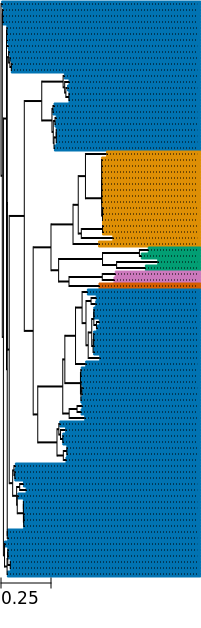

In [58]:
fig_tree=plot_tree(zeqian_tree,zeqian_taxa, colormap=colormap, taxa_level=level,extend=0.2)
fig_tree

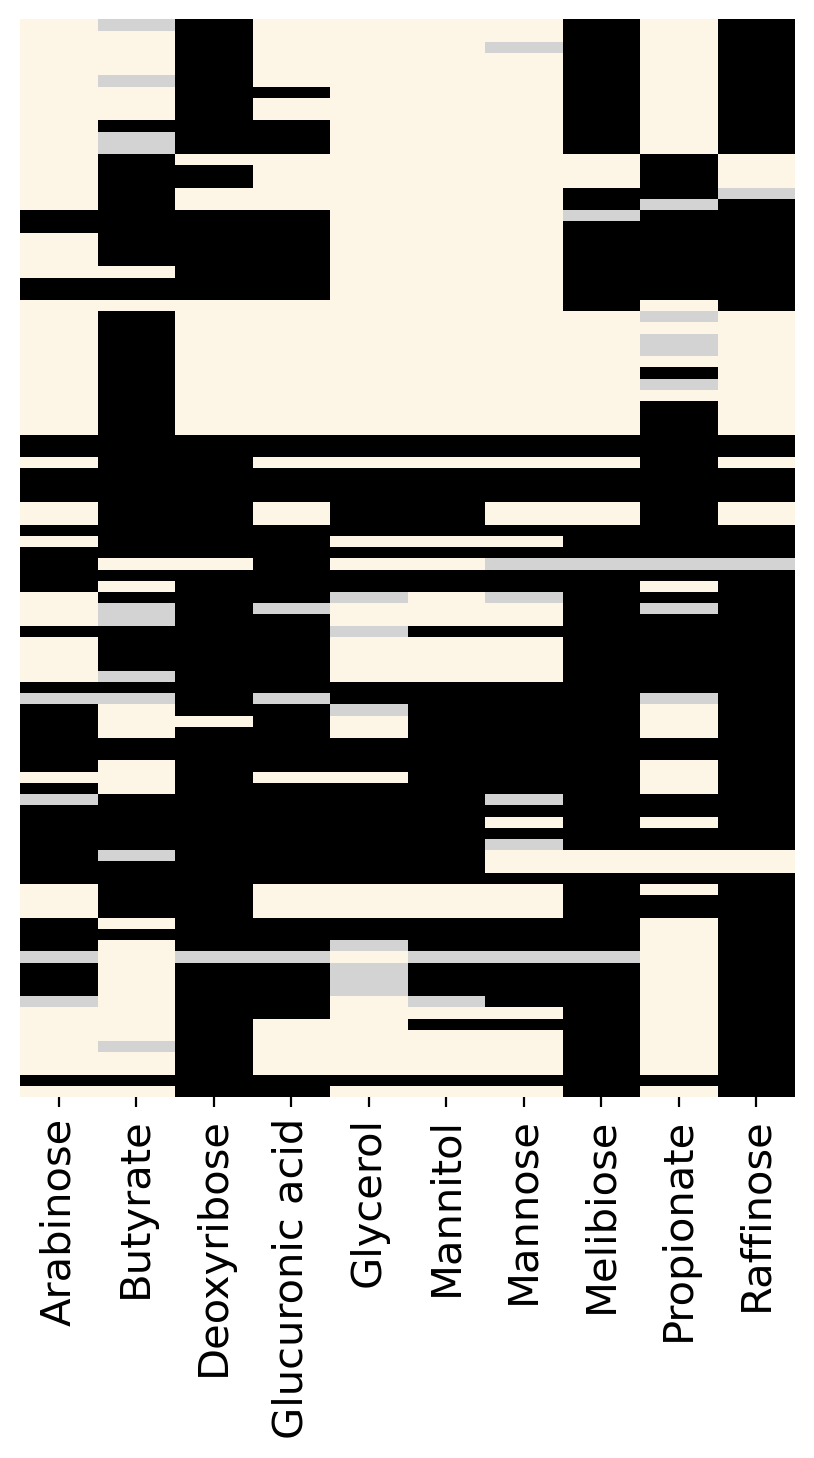

In [59]:
fig_growth=plot_growth_data(zeqian['growth_data'].loc[[n.name for n in zeqian_tree.get_leaves()],:])

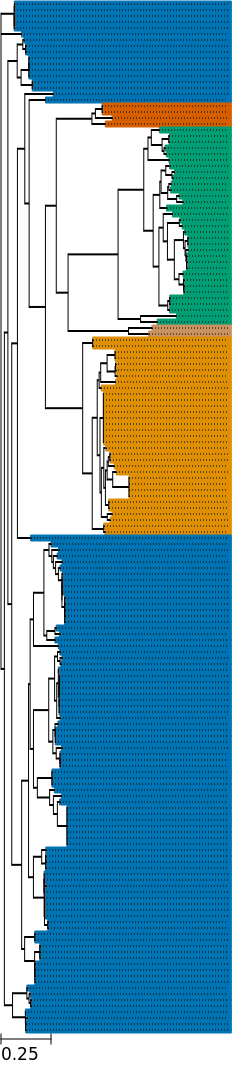

In [60]:
fig_tree=plot_tree(matti_tree,matti_taxa, colormap=colormap, taxa_level=level,extend=0.2)
fig_tree

In [73]:
len(matti['samples'])

172

In [6]:
import  scipy.cluster.hierarchy as  hierarchy

def cluster_matrix(matrix, axis=0, metric=None, **kwargs):
    """ Hierarchical cluster a matrix. 
    
    """
    if axis == 1:
        return cluster_matrix(matrix.T, axis=0, metric=metric, **kwargs).T

    if metric is None:
        def metric(x, y):
            x = (x > 0).astype(int)
            y = (y > 0).astype(int)
            # -np.logical_and(np.isnan(x),np.isnan(y)).sum())
            return 1-(x == y).sum()/len(x)
    Z = hierarchy.linkage(matrix, metric=metric, **kwargs)

    return matrix.iloc[hierarchy.leaves_list(Z), :]


In [ ]:
fig_growth=plot_growth_data(cluster_matrix(matti['growth_data'].loc[[n.name for n in matti_tree.get_leaves()],:],axis=1),xticklabels=False)

# BacDive

In [4]:
bacdive=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")

Text(0.5, 133.16666666666663, '')

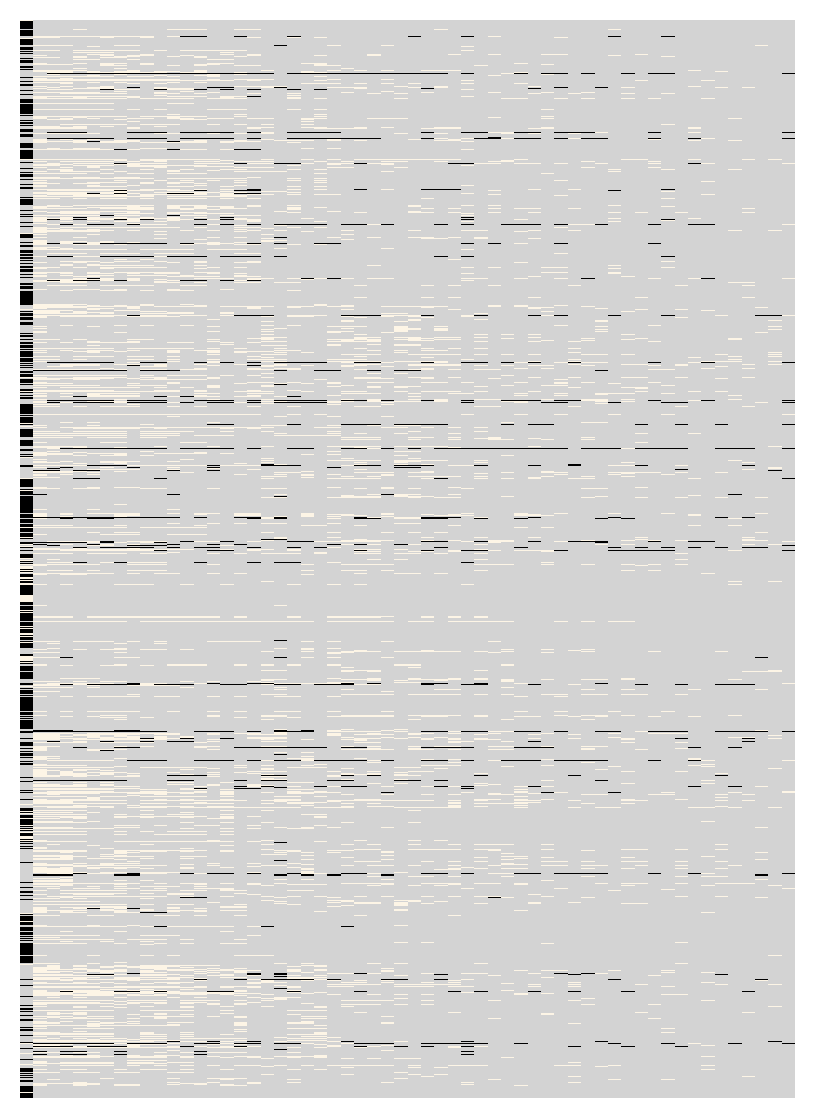

In [9]:
# Bacdive
df=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")['growth_data']
df=df.iloc[:,np.argsort(df.count(axis=0).values)[::-1]]
# df=cluster_matrix(df,axis=0)
df=df.loc[[n.name for n in bacdive['tree'].get_leaves()],:]

#fig=plot_growth_data(df.iloc[np.random.choice(df.shape[0],500),:30])
fig_growth=plot_growth_data(df,xticklabels=False)

plt.xlabel(None)

### Bacdive tree (Figure 4)

In [23]:
bacdive=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive.pk")

tree=bacdive['tree'].copy()
leaves=[n.name for n in tree.get_leaves() if tree.get_distance(n.name)<40]
tree.prune(leaves, preserve_branch_length=True)


In [24]:
highlight=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/bacdive_rnf/better_strains.pk")
highlight=highlight[highlight>0.5]

In [6]:
highlight

136990    1.000000
253       1.000000
13509     1.000000
15333     1.000000
15379     1.000000
            ...   
17307     0.555831
132975    0.555714
17304     0.536600
132425    0.522927
130522    0.501544
Length: 188, dtype: float64

In [7]:


bacdive_taxa=load_taxonomy_file("/home/zeqianli/project/zeqian/Carbon/data/bacdive/bacdive_16S.aligned.csv")
orders=['Enterobacterales','Pseudonocardiales']
taxa_highlights=[bacdive_taxa[bacdive_taxa['order']==order].index.values for order in orders]

In [22]:
bacdive_taxa.loc[highlight.index.values]['order'].value_counts()

Enterobacterales       118
Pseudonocardiales       30
Streptomycetales         7
Burkholderiales          7
Bacillales               3
Micromonosporales        3
Rhodobacterales          3
Corynebacteriales        3
Sphingobacteriales       2
Oscillospirales          2
Pseudomonadales          2
Bacteroidales            2
Propionibacteriales      1
Streptosporangiales      1
Glycomycetales           1
Cardiobacteriales        1
Flavobacteriales         1
Bifidobacteriales        1
Name: order, dtype: int64

In [27]:
for node in tree.get_leaves():
    if node.name in taxa_highlights[0]:
        ns=ete3.NodeStyle()
        ns['bgcolor']='blue'
        ns['size']=5
        node.set_style(ns)
    
    if node.name in taxa_highlights[1]:
        ns=ete3.NodeStyle()
        ns['bgcolor']='green'
        ns['size']=5
        node.set_style(ns)
    

In [28]:
for n, value in highlight.items():
    node=tree.get_leaves_by_name(n)[0]
    ns=ete3.NodeStyle()
    
    ns['bgcolor']='red'
    ns['size']=20
    node.set_style(ns)

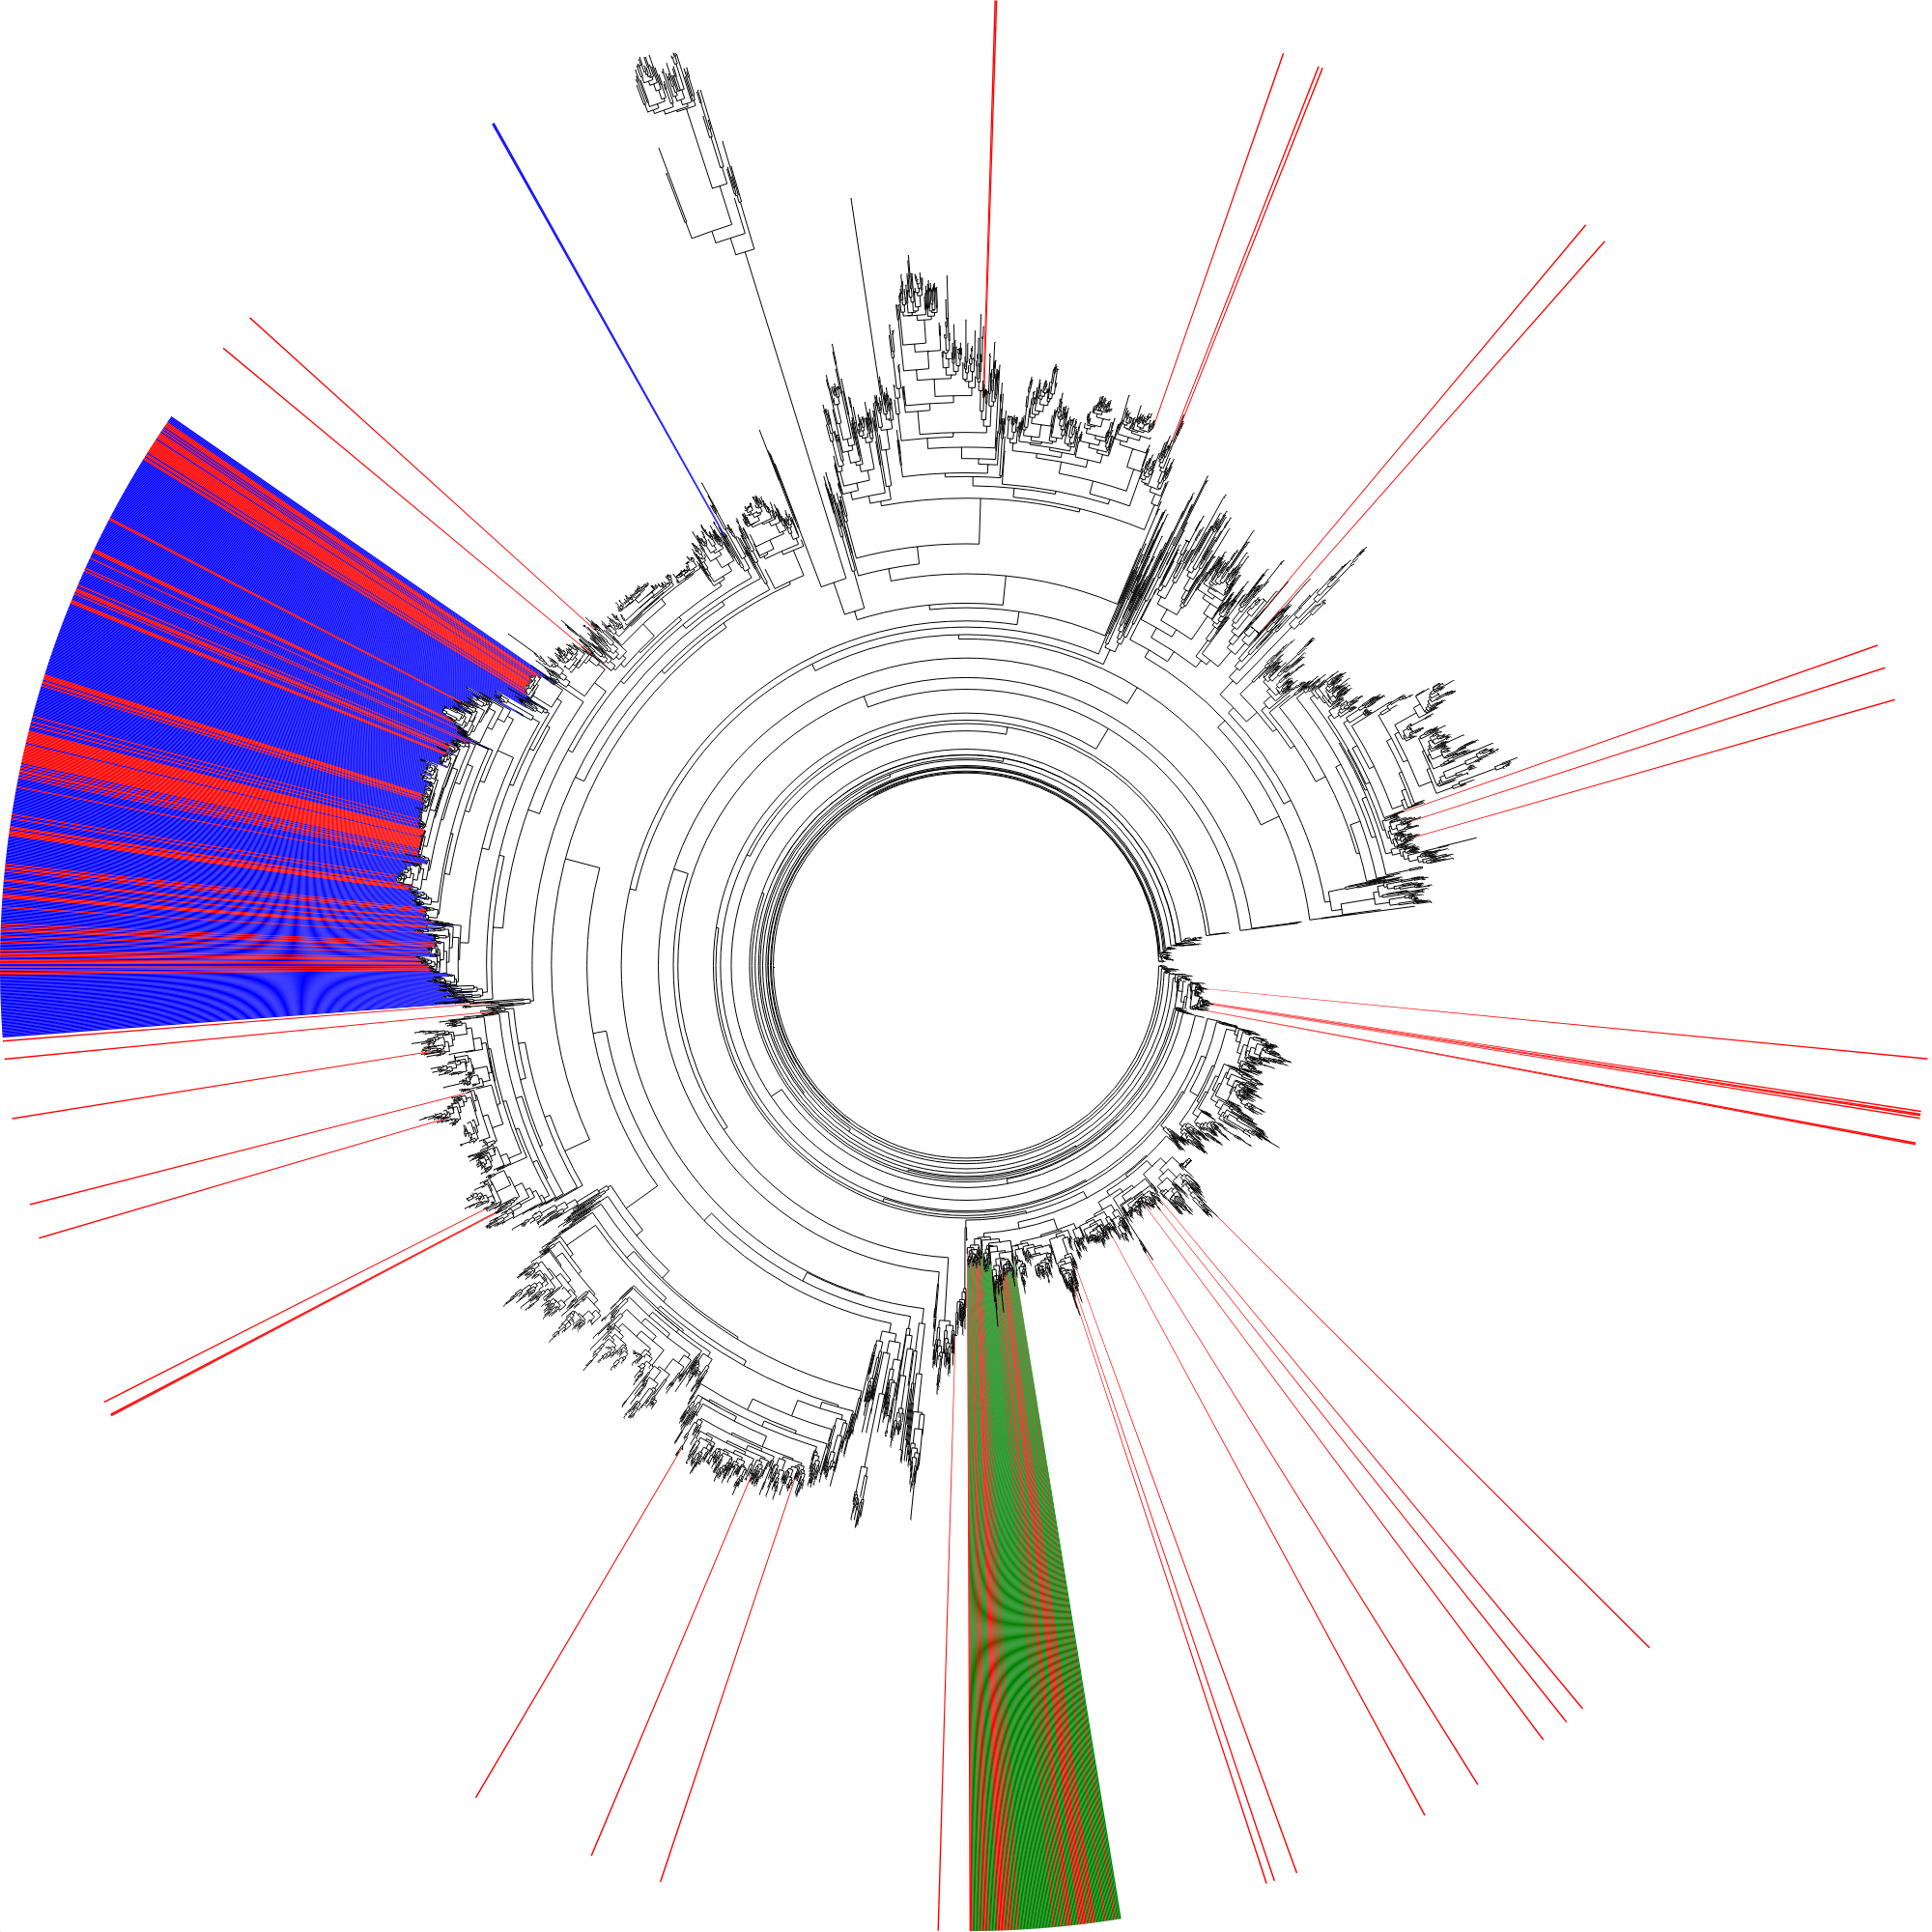

In [29]:
ts=ete3.TreeStyle()

ts.show_leaf_name=False
ts.mode = "c"
# ts.arc_start = -180 # 0 degrees = 3 o'clock
# ts.arc_span = 180
tree.render("%%inline",tree_style=ts,w=2000,h=2000)